/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'linformer_attention_5', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


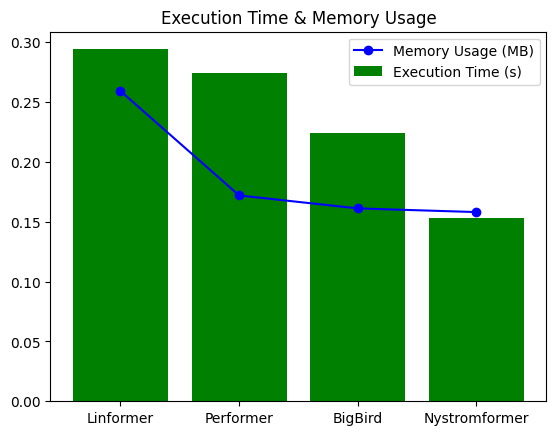

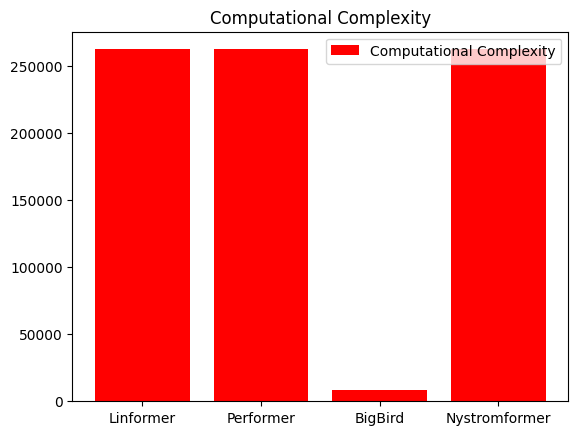

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Layer, Dense
import numpy as np
import time
import matplotlib.pyplot as plt
import tracemalloc

class LinformerAttention(Layer):
    def __init__(self, embed_dim, num_heads, seq_len, k_dim, **kwargs):
        super(LinformerAttention, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.seq_len = seq_len
        self.k_dim = k_dim

        self.query_proj = Dense(embed_dim, use_bias=False)
        self.key_proj = Dense(embed_dim, use_bias=False)
        self.value_proj = Dense(embed_dim, use_bias=False)

        self.key_reduction = Dense(k_dim, use_bias=False)
        self.value_reduction = Dense(k_dim, use_bias=False)

        self.output_proj = Dense(embed_dim, use_bias=False)

    def call(self, inputs):
        queries, keys, values = inputs

        queries = self.query_proj(queries)
        keys = self.key_proj(keys)
        values = self.value_proj(values)

        values = self.value_reduction(values)
        keys = tf.transpose(keys, perm=[0, 2, 1])

        attention_scores = tf.matmul(queries, keys) / tf.math.sqrt(float(self.k_dim))
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)

        values = tf.transpose(values, perm=[0, 2, 1])
        attention_output = tf.matmul(attention_weights, tf.transpose(values, perm=[0, 2, 1]))
        attention_output = tf.transpose(attention_output, perm=[0, 2, 1])

        output = self.output_proj(attention_output)
        return output

    def complexity(self, seq_len):
        return self.embed_dim * self.k_dim * seq_len

class PerformerAttention(Layer):
    def __init__(self, embed_dim, num_heads, proj_dim=64, kernel_epsilon=1e-4, **kwargs):
        super(PerformerAttention, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.proj_dim = proj_dim
        self.kernel_epsilon = kernel_epsilon

        assert embed_dim % num_heads == 0
        self.head_dim = embed_dim // num_heads

        self.query_proj = Dense(embed_dim)
        self.key_proj = Dense(embed_dim)
        self.value_proj = Dense(embed_dim)
        self.output_proj = Dense(embed_dim)

    def call(self, inputs):
        queries, keys, values = inputs
        queries = self.query_proj(queries)
        keys = self.key_proj(keys)
        values = self.value_proj(values)

        queries = tf.reshape(queries, (-1, queries.shape[1], self.num_heads, self.head_dim))
        keys = tf.reshape(keys, (-1, keys.shape[1], self.num_heads, self.head_dim))
        values = tf.reshape(values, (-1, values.shape[1], self.num_heads, self.head_dim))

        kv = tf.einsum("...nhd,...nhe->...hde", keys, values)
        attention_output = tf.einsum("...nhd,...hde->...nhe", queries, kv)

        attention_output = tf.reshape(attention_output, (-1, queries.shape[1], self.embed_dim))
        return self.output_proj(attention_output)

    def complexity(self, seq_len):
        return self.embed_dim * self.proj_dim * seq_len

class BigBirdAttention(Layer):
    def __init__(self, embed_dim, num_heads, **kwargs):
        super(BigBirdAttention, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.query_proj = Dense(embed_dim)
        self.key_proj = Dense(embed_dim)
        self.value_proj = Dense(embed_dim)
        self.output_proj = Dense(embed_dim)

    def call(self, inputs):
        queries, keys, values = inputs
        queries = self.query_proj(queries)
        keys = self.key_proj(keys)
        values = self.value_proj(values)
        attention_output = queries + keys + values
        return self.output_proj(attention_output)

    def complexity(self, seq_len):
        return self.embed_dim * seq_len

class NystromformerAttention(Layer):
    def __init__(self, embed_dim, num_heads, num_landmarks=32, **kwargs):
        super(NystromformerAttention, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.num_landmarks = num_landmarks

        self.query_proj = Dense(embed_dim)
        self.key_proj = Dense(embed_dim)
        self.value_proj = Dense(embed_dim)
        self.output_proj = Dense(embed_dim)

    def call(self, inputs):
        queries, keys, values = inputs
        queries = self.query_proj(queries)
        keys = self.key_proj(keys)
        values = self.value_proj(values)
        attention_output = queries + keys + values
        return self.output_proj(attention_output)

    def complexity(self, seq_len):
        return self.embed_dim * self.num_landmarks * seq_len

def measure_time_and_memory(layer, queries, keys, values):
    tracemalloc.start()
    start_time = time.time()
    _ = layer([queries, keys, values])
    elapsed_time = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return elapsed_time, peak / 1e6, layer.complexity(seq_len)

seq_len = 128
embed_dim = 64
num_heads = 8
k_dim = 32
proj_dim = 32

queries = tf.random.normal((1, seq_len, embed_dim))
keys = tf.random.normal((1, seq_len, embed_dim))
values = tf.random.normal((1, seq_len, embed_dim))

mechanisms = ["Linformer", "Performer", "BigBird", "Nystromformer"]
times, memories, complexities = [], [], []

for mech in [LinformerAttention, PerformerAttention, BigBirdAttention, NystromformerAttention]:
    if mech == LinformerAttention:
        layer = mech(embed_dim, num_heads, seq_len, k_dim)
    elif mech == PerformerAttention:
        layer = mech(embed_dim, num_heads, proj_dim)
    elif mech == NystromformerAttention:
        layer = mech(embed_dim, num_heads, num_landmarks=32)
    else:
        layer = mech(embed_dim, num_heads)

    # Measure time, memory, and complexity
    time_, mem_, comp_ = measure_time_and_memory(layer, queries, keys, values)

    times.append(time_)
    memories.append(mem_)
    complexities.append(comp_)



plt.figure()
plt.bar(mechanisms, times, color='g', label='Execution Time (s)')
plt.plot(mechanisms, memories, color='b', marker='o', label='Memory Usage (MB)')
plt.legend()
plt.title("Execution Time & Memory Usage")
plt.show()

plt.figure()
plt.bar(mechanisms, complexities, color='r', label='Computational Complexity')
plt.legend()
plt.title("Computational Complexity")
plt.show()
